## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [75]:
##%tensorflow_version 2.x
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from zipfile import ZipFile
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [76]:
##project_path = "/content/drive/My Drive/AIML_Project/Dog_breed/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [6]:
from zipfile import ZipFile
with ZipFile('train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [7]:
with ZipFile('test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [8]:
with ZipFile('sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [9]:
with ZipFile('labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [77]:
labels = pd.read_csv('labels.csv', encoding = "ISO-8859-1" )

In [78]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


### Print the count of each category of Dogs given in the dataset



In [79]:
print(labels.breed.value_counts())

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


### Get one-hot encodings of labels

In [80]:
le = preprocessing.LabelEncoder()

In [81]:
labels.breed = le.fit_transform(labels.breed)

In [82]:
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,18
10218,ffd3f636f7f379c51ba3648a9ff8254f,35
10219,ffe2ca6c940cddfee68fa3cc6c63213f,3
10220,ffe5f6d8e2bff356e9482a80a6e29aac,75


## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [83]:
img_rows = 128
img_cols = 128
labels.shape

(10222, 2)

In [84]:
x_train = []
y_train = []
for ii, label in tqdm(labels.iterrows()):
  train_image = cv2.imread('train/{}.jpg'.format(label.id), 1)
  train_image_resize = cv2.resize(train_image, (img_rows,img_cols))
  x_train.append(train_image_resize.astype('float32') / 255)
  y_train.append(label.breed)

10222it [03:04, 55.49it/s]


Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [85]:
x_train_data = np.asarray(x_train)

In [86]:
y_train_data = pd.get_dummies(y_train)
y_train_data = np.asarray(y_train_data)

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [87]:
x_train_data.shape, y_train_data.shape

((10222, 128, 128, 3), (10222, 120))

In [88]:
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(x_train_data, y_train_data, test_size=0.2, random_state=42)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [89]:
test = pd.read_csv('sample_submission.csv')
test_img = test['id']

Run the below code to load the test image files in x_test_feature

In [90]:
x_test_feature = []
i = 0 # initialisation
for f in tqdm(test_img.values): # f for format ,jpg
    img = cv2.imread('./test/{}.jpg'.format(f), 0)
    img_resize = cv2.resize(img, (img_rows, img_cols)) 
    x_test_feature.append(img_resize)

100%|████████████████████████████████████████████████████████████████████████████| 10357/10357 [01:52<00:00, 91.67it/s]


Normalize the test data and convert it into 4 dimensions

In [91]:
np.array(x_test_feature).shape

(10357, 128, 128)

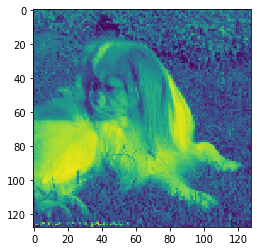

In [92]:
plt.imshow(x_test_feature[0])

In [93]:
#x_train_data = x_train_data/255
#x_test_data = x_test_data/255

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [47]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Flatten,Dense,Dropout,BatchNormalization,Activation

In [48]:
import tensorflow as tf
import keras

In [49]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(5,3),input_shape=(128,128,3)))
model.add(Activation('relu'))

model.add(Conv2D(32,kernel_size=(5,3)))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(120, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 126, 32)      1472      
_________________________________________________________________
activation_1 (Activation)    (None, 124, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 124, 32)      15392     
_________________________________________________________________
activation_2 (Activation)    (None, 120, 124, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 62, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 119040)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [50]:

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

### Use batch_size = 128 and epochs = 10 and execute the model

In [31]:
model.fit(x=x_train_data,y=y_train_data,batch_size=128,epochs=10,validation_data=(x_test_data, y_test_data))

Instructions for updating:
Use tf.cast instead.
Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - 243s 30ms/step - loss: 4.6078 - accuracy: 0.0324 - val_loss: 8.0722 - val_accuracy: 0.0088
Epoch 2/10
8177/8177 [==============================] - 241s 30ms/step - loss: 4.2390 - accuracy: 0.0792 - val_loss: 8.3829 - val_accuracy: 0.0108
Epoch 3/10
8177/8177 [==============================] - 241s 29ms/step - loss: 3.9120 - accuracy: 0.1487 - val_loss: 8.3155 - val_accuracy: 0.0127
Epoch 4/10
8177/8177 [==============================] - 244s 30ms/step - loss: 3.1322 - accuracy: 0.3747 - val_loss: 13.6472 - val_accuracy: 0.0147
Epoch 5/10
8177/8177 [==============================] - 244s 30ms/step - loss: 2.0040 - accuracy: 0.7129 - val_loss: 15.6544 - val_accuracy: 0.0049
Epoch 6/10
8177/8177 [==============================] - 242s 30ms/step - loss: 1.0089 - accuracy: 0.9155 - val_loss: 14.8816 - val_accuracy: 0.0132
Epoch 7/10
8177/817

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [94]:
from keras.preprocessing.image import ImageDataGenerator

In [95]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False) 

In [96]:
datagen.fit(x_train_data)

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [97]:
train_generator = datagen.flow(x_train_data, y_train_data)
val_generator = datagen.flow(x_test_data, y_test_data)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [37]:
model.fit(train_generator, validation_data=val_generator, steps_per_epoch=128, epochs=10)

Epoch 1/10
128/128 [==============================] - 158s 1s/step - loss: 4.9819 - accuracy: 0.0225 - val_loss: 16.1181 - val_accuracy: 0.0083
Epoch 2/10
128/128 [==============================] - 157s 1s/step - loss: 4.6366 - accuracy: 0.0255 - val_loss: 16.1181 - val_accuracy: 0.0088
Epoch 3/10
128/128 [==============================] - 156s 1s/step - loss: 4.5649 - accuracy: 0.0326 - val_loss: 16.1181 - val_accuracy: 0.0122
Epoch 4/10
128/128 [==============================] - 156s 1s/step - loss: 4.5515 - accuracy: 0.0356 - val_loss: 16.0697 - val_accuracy: 0.0088
Epoch 5/10
128/128 [==============================] - 156s 1s/step - loss: 4.5022 - accuracy: 0.0365 - val_loss: 14.6185 - val_accuracy: 0.0132
Epoch 6/10
128/128 [==============================] - 156s 1s/step - loss: 4.4998 - accuracy: 0.0342 - val_loss: 15.3940 - val_accuracy: 0.0064
Epoch 7/10
128/128 [==============================] - 156s 1s/step - loss: 4.4631 - accuracy: 0.0413 - val_loss: 16.1181 - val_accuracy:

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [98]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg')

Print the summary of the base_model

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [99]:
from keras import models
from keras import optimizers

In [100]:
tf.keras.backend.clear_session()

#Create a new model
model_new = tf.keras.models.Sequential()

#Add the base VGG model
model_new.add(base_model)

#Flatten the output
model_new.add(tf.keras.layers.Flatten())

#First Dense layer
model_new.add(tf.keras.layers.Dense(1024, activation='relu'))

model_new.add(tf.keras.layers.Dropout(0.25))

#Second Dense layer
model_new.add(tf.keras.layers.Dense(256, activation='relu'))

model_new.add(tf.keras.layers.Dropout(0.25))

#Third Dense layer
model_new.add(tf.keras.layers.Dense(120, activation='softmax'))

In [101]:
model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               3

### Make all the layers in the base_model (VGG16) to be non-trainable

In [102]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [103]:
for layer in base_model.layers:
    layer.trainable = False
    if("block5_conv3" in layer.name):
        print(layer.name)
        layer.trainable = True

block5_conv3


In [104]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [105]:
model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('cv_project_model.h5', 
                                                    save_best_only=True, 
                                                    monitor='accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [106]:
#Fit the first model with the given dataset
model_new.fit(train_generator, validation_data=val_generator,
              steps_per_epoch=128, epochs=10, callbacks=[model_checkpoint])

#model_new.fit(x=x_train_data,y=y_train_data,batch_size=128,epochs=10,validation_data=(x_test_data, y_test_data), callbacks=[model_checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128 steps, validate for 64 steps
Epoch 1/10
127/128 [============================>.] - ETA: 3s - loss: 4.7977 - accuracy: 0.0141
Epoch 00001: accuracy improved from 0.01370 to 0.01397, saving model to cv_project_model.h5
128/128 [==============================] - 568s 4s/step - loss: 4.7973 - accuracy: 0.0140 - val_loss: 4.7336 - val_accuracy: 0.0215
Epoch 2/10
127/128 [============================>.] - ETA: 3s - loss: 4.6334 - accuracy: 0.0342
Epoch 00002: accuracy improved from 0.01397 to 0.03394, saving model to cv_project_model.h5
128/128 [==============================] - 568s 4s/step - loss: 4.6347 - accuracy: 0.0339 - val_loss: 4.4784 - val_accuracy: 0.0377
Epoch 3/10
127/128 [============================>.] - ETA: 2s - loss: 4.3445 - accuracy: 0.0479
Epoch 00003: accuracy improved from 0.03394 to 0.04827, saving model to cv_project_model.h5
128/128 [==============================] - 566s 4s/step - loss: 4.3417 - accura

### Conclusion
<br>1. It was resource intensive operations and the max accuracy that we could achieve is 17.8%
<br>2. We can see accuracy improving with Epochs. We can try more epochs and alter batchsize to get more accuracy.
<br>3. We see accuracy improving quite nicely with vgg16 weights. But still accuracy is not upto the mark. The entire model can be tuned further for getting more accuracy